<small><i>This notebook was create by Franck Iutzeler, Jerome Malick and Yann Vernaz (2016).</i></small>
<!-- Credit (images) Jeffrey Keating Thompson. -->

<center><img src="UGA.png" width="30%" height="30%"></center>
<center><h3>Master of Science in Industrial and Applied Mathematics (MSIAM)</h3></center>
<hr>
<center><h1>Convex and distributed optimization</h1></center>
<center><h2>Part III - Recommender Systems (3h + 3h home work)</h2></center>

# Outline

In this Lab, we will investigate some gradient-based algorithms on the very well known matrix factorization problem which is the most prominent approach for build a _Recommender Systems_.

Our goal is to implement Large-Scale Matrix Factorization with Distributed Stochastic Gradient Descent in Spark.

# Problem Formulation

The problem of matrix factorization for collaborative filtering captured much attention, especially after the [Netflix prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf). The premise behind this approach is to approximate a large rating matrix $R$ with the multiplication of two low-dimensional factor matrices $P$ and $Q$, i.e. $R \approx \hat{R} = P^TQ$, that model respectively users and items in some latent space. For instance, matrix $R$ has dimension $m \times  n$ where $m$ and $n$ are restrictively the number of users and items, both large; while $P$ has size $m \times  k$ and contains user information in a latent space of size $k<<m,n$, $Q$ has size $n\times k$ and contains item information in the same latent space of size $k << m,n$. Typical values for $m, n$ are $10^6$ while $k$ is in the tens.

For a pair of user and item $(u_i,i_j)$ for which a rating $r_{ij}$ exists, a common approach approach is based on the minimization of the $\ell_2$-regularized quadratic error:
$$  \ell_{u_i,i_j}(P,Q)= \left(r_{ij} - p_{i}^{\top}q_{j}\right)^2 + \lambda(|| p_{i} ||^{2} + || q_{j} ||^2 )  $$
where $p_i$ is the column vector composed of the $i$-th line of $P$ and  $\lambda\geq 0$ is a regularization parameter. The whole matrix factorization problem thus writes
$$ \min_{P,Q} \sum_{i,j : r_{ij} \text{exists}}  \ell_{u_i,i_j}(P,Q). $$
Note that the error $ \ell_{u_i,i_j}(P,Q)$ depends only on $P$ and $Q$ through $p_{i}$ and $q_{j}$; however, item $i_j$ may also be rated by user $u_{i'}$ so that the optimal factor $q_{j}$ depends on both $p_{i}$ and $p_{i'}$.

In [1]:
# set up spark environment (Using Spark Local Mode)
from pyspark import SparkContext, SparkConf

conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("MSIAM part III - Matrix Factorization")

sc = SparkContext(conf = conf)

We remind you that you can access this interface by simply opening http://localhost:4040 in a web browser.

We will capitalize on the first lab and take the MovieLens dataset, and thus the RDD routines we already have.

In [2]:
def parseRating(line):
    fields = line.split('::')
    return int(fields[0]), int(fields[1]), float(fields[2])

def parseMovie(line):
    fields = line.split("::")
    return int(fields[0]), fields[1], fields[2]

# path to MovieLens dataset
movieLensHomeDir="data/movielens/medium/"

# ratings is an RDD of (userID, movieID, rating)
ratingsRDD = sc.textFile(movieLensHomeDir + "ratings.dat").map(parseRating).setName("ratings").cache()

numRatings = ratingsRDD.count()
numUsers = ratingsRDD.map(lambda r: r[0]).distinct().count()
numMovies = ratingsRDD.map(lambda r: r[1]).distinct().count()
print("We have %d ratings from %d users on %d movies.\n" % (numRatings, numUsers, numMovies))

M = ratingsRDD.map(lambda r: r[0]).max()
N = ratingsRDD.map(lambda r: r[1]).max()
matrixSparsity = float(numRatings)/float(M*N)
print("We have %d users, %d movies and the rating matrix has %f percent of non-zero value.\n" % (M, N, 100*matrixSparsity))

We have 1000209 ratings from 6040 users on 3706 movies.

We have 6040 users, 3952 movies and the rating matrix has 4.190221 percent of non-zero value.



#  Gradient Descent Algorithms

The goal here is to 
1. Compute gradients of the loss functions.
2. Implement gradient algorithms.
3. Observe the prediction accuracy of the developed methods.

__Question 1__

> Split (ramdomly) the dataset into training versus testing sample. We learn over 70% (for example) of the users, we test over the rest.

> Define a routine that returns the predicted rating from factor matrices. Form a RDD with the following elements `(i,j,true rating,predicted rating)`. 

> Define a routine that returns the Mean Square Error (MSE).


In [4]:
import numpy as np

trainingSample, testingSample = ratingsRDD.randomSplit([70, 30])
print("The number of examples in the dataset : ",ratingsRDD.count())
print("The number of examples in the training dataset : ",trainingSample.count())
print("The number of examples in the testing dataset : ",testingSample.count())

numUsers = trainingSample.map(lambda r: r[0]).distinct().count()
usersList = trainingSample.map(lambda r: r[0]).distinct().collect()
numMovies = trainingSample.map(lambda r: r[1]).distinct().count()
moviesList = trainingSample.map(lambda r: r[1]).distinct().collect()
print("We have %d users and %d movies in training sample.\n" % (numUsers, numMovies))

The number of examples in the dataset :  1000209
The number of examples in the training dataset :  699883
The number of examples in the testing dataset :  300326
We have 6040 users and 3657 movies in training sample.



In [73]:
# Test
import random

def choixMovies(n):
    movieTestList = []
    pas = int(numMovies/n)
    intervalle = 0
    for i in range(0,n): 
        movieTestList.append(random.randint(intervalle,intervalle+pas))
        intervalle += pas
    return movieTestList
     
def getRealRating(u,i):
    rating = trainingSample.filter(lambda x : x[0] == u).filter(lambda y : y[1] == i).map(lambda z : z[2]).collect()
    if len(rating) == 0:
        return -1
    return rating[0]

def correspondingUsers(movies):
    _users = {}
    for m in usersList:
        _users_temp = {m:0} 
        _users.update(_users_temp)
        
    for movie in movies:
        nb = 0
        _correspondingUsers = trainingSample.filter(lambda line : line[1] == movie).map(lambda line : line[0]).collect()
        for i in _correspondingUsers:
            _users[i] = _users[i] + 1  
    final_list = []
    for i in _users:
        if _users[i] == len(movies):
            final_list.append(i)
    return final_list
                              
moviesTest = choixMovies(3)
print("\n",len(moviesTest),"distinct random movies:\n",moviesTest)
usersTest = correspondingUsers(moviesTest)
print("\n",len(usersTest),"distinct users:\n",usersTest)


 3 distinct random movies:
 [610, 1983, 3362]

 19 distinct users:
 [651, 1128, 1285, 1680, 1733, 1820, 1941, 2181, 2909, 3032, 3626, 3841, 4009, 4041, 4064, 4227, 4238, 4303, 5627]


In [74]:
# Optimal test sample
#moviesTest = [733, 1513, 3052]
#usersTest = [149, 242, 424, 528, 710, 781, 1001, 1088, 1113, 1125, 1172, 1181, 1194, 1303, 1391, 1449, 1542, 1666, 1733, 1764, 1778, 1854, 2010, 2063, 2106, 2116, 2378, 2559, 2777, 2793, 2818, 2996, 3189, 3203, 3308, 3336, 3434, 3464, 3471, 3504, 3539, 3648, 3652, 3859, 4041, 4186, 4404, 4446, 4485, 4728, 4829, 4979, 5605, 5643, 5795, 5956, 5972]

# Build factorization matrix
from random import *

def randomArray(size,a,b) :
    x = np.zeros(size)
    for i in range(0,size) :
        x[i] = uniform(a,b)
    return x

def MSE(pu,qi,lamb,rij,rijHat):
    e = pow(rij - rijHat,2) + lamb * (pow(np.linalg.norm(pu,2),2) + pow(np.linalg.norm(qi,2),2))
    return e

def getPredictiveRating(u,i,mat):
    return mat[u,i]

m = len(usersTest)
n = len(moviesTest)
k = 5
lamb = 0.01
factorMatrix = np.eye(m,n)
matrixRating = np.eye(m,n)
for u in range(0,m):
    print(u,end=' ')
    pu = randomArray(k,-1,1)
    for i in range(0,n):
        qi = randomArray(k,-1,1)
        factorMatrix[u,i] = np.dot(pu,qi)
        matrixRating[u,i] = getRealRating(usersTest[u],moviesTest[i])
testing = matrixRating[1,1]
matrixRating[1,1] = -1
print("\n testing matrixRating",1,1, "=",testing,"\n")
print("\n",matrixRating)
print("\n",factorMatrix)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 
 testing matrixRating 1 1 = 2.0 


 [[ 4.  2.  4.]
 [ 3. -1.  3.]
 [ 3.  2.  5.]
 [ 4.  5.  4.]
 [ 3.  3.  4.]
 [ 3.  5.  5.]
 [ 3.  3.  5.]
 [ 1.  3.  5.]
 [ 3.  4.  4.]
 [ 3.  5.  5.]
 [ 4.  3.  4.]
 [ 3.  3.  4.]
 [ 1.  4.  5.]
 [ 2.  4.  4.]
 [ 2.  2.  4.]
 [ 4.  1.  4.]
 [ 3.  3.  4.]
 [ 4.  1.  4.]
 [ 4.  2.  4.]]

 [[ 0.23788554 -0.59821441 -0.00691115]
 [-0.72081882  0.37020607  1.13802721]
 [ 1.28376753 -0.2032138  -0.01931199]
 [ 0.16409554  0.15517308  0.17776166]
 [ 0.47301634 -0.16008854  0.12836467]
 [ 0.12867501 -0.01140444  0.08502107]
 [ 0.36477571 -0.07061426 -0.03297658]
 [ 1.51280615  0.29162757 -0.02627755]
 [ 0.28607742  0.43003809 -0.5533222 ]
 [ 0.87686779 -0.19194513  0.79675142]
 [ 0.0088413  -0.06072406 -0.12023561]
 [ 0.17613234 -0.25068132  0.23736077]
 [-0.91357012 -0.81294482  0.91135921]
 [ 0.05394769  0.03238511  0.1033972 ]
 [ 0.02949401 -0.66482824 -0.59836994]
 [-0.79673206  0.64509971 -0.42137616]
 [ 0

In [7]:
# Create predictive ratings RDD
def mat2Rdd(m,n,estimatedMatrix):
    mat = []
    for u in range(0,m):
        for i in range(0,n):
            mat.append((usersTest[u],moviesTest[i],estimatedMatrix[u,i],matrixRating[u,i]))
    rdd = sc.parallelize(mat)
    print("Convertion of factor matrix to RDD: OK")
    return rdd

predictiveRatingsRDD = mat2Rdd(m,n,factorMatrix)
print("Predictive Ratings RDD :\n",predictiveRatingsRDD.collect())

Convertion of factor matrix to RDD: OK
Predictive Ratings RDD :
 [(149, 733, -0.35168353445225575, -1.0), (149, 1513, -0.13062075609712231, 4.0), (149, 3052, 0.12149808980686669, -1.0), (242, 733, -0.86668911265325532, 3.0), (242, 1513, -0.66268657590149471, 3.0), (242, 3052, -0.29894447915497058, 3.0), (424, 733, 0.034176361977205763, -1.0), (424, 1513, 0.37110895639771541, 3.0), (424, 3052, 0.22796575291902799, -1.0), (528, 733, 0.24643255548815685, 4.0), (528, 1513, -0.1305569358722235, 2.0), (528, 3052, -0.50806772614849716, 4.0), (710, 733, 0.77368510649258848, 4.0), (710, 1513, 0.7713932078665966, -1.0), (710, 3052, -0.55702380869345003, 4.0), (781, 733, 0.4864693425295008, 4.0), (781, 1513, -0.38406606177302466, 3.0), (781, 3052, 1.0430728353405962, -1.0), (1001, 733, -0.402698276015026, 4.0), (1001, 1513, -0.86611587558662007, 3.0), (1001, 3052, -0.12393081582999782, -1.0), (1088, 733, -0.29561807798738865, 4.0), (1088, 1513, -0.43305495250480497, -1.0), (1088, 3052, 0.30280273

$$  \ell_{u_i,i_j}(P,Q)= \left(r_{ij} - p_{i}^{\top}q_{j}\right)^2 + \lambda(|| p_{i} ||^{2} + || q_{j} ||^2 )  $$

__Question 2__

> Derive the update rules for gradient descent. 

> Implement a (full) gradient algorithm in `Python` on the training set.  Take a step size (learning rate) $\gamma=0.001$ and stop after a specified number of iterations. Investigate the latent space size (e.g. $K=2,5,10,50$).

> Provide plots and explanations for your experiments. 

> Try to parrallelize it so that the code can be run using `PySpark`. What do you conclude?

Stochastic Gradient Descent (SGD) simply does away with the expectation in the update and computes the gradient of the parameters using only a single or a few training examples. In SGD the learning rate $\gamma$ is typically much smaller than a corresponding learning rate in batch gradient descent because there is much more variance in the update.

In [106]:
import numpy as np

MAX_ITER = 1000

def MSE(pu,qi,lamb,rij,rijHat):
    e = pow(rij - rijHat,2) + lamb * (pow(np.linalg.norm(pu,2),2) + pow(np.linalg.norm(qi,2),2))
    return e

def MSE_grad(pu,qi,lamb,rij,rijHat):
    _grad_p = - 2 * qi * (rij - rijHat) + 2 * lamb * pu
    _grad_q = - 2 * pu * (rij - rijHat) + 2 * lamb * qi
    return  (_grad_p, _grad_q)

#def grad_algo(u,i,k,lamb,nb_iter,rdd,index):
#    t = 0
#    gamma = 0.001
#    pu = randomArray(k,-1,1)
#    qi = randomArray(k,-1,1)
#    rijHat = np.dot(pu,qi)
#    rij =  rdd.filter(lambda x : x[0]==u).filter(lambda x : x[1]==i)\
#                                    .map(lambda x : x[index]).collect()[0]
#    mse_tab = np.zeros(nb_iter)
#    
#    while t < nb_iter:
#        #print(i, end=' ')
#        mse_grad = MSE_grad(pu,qi,lamb,rij,rijHat)
#        mse_tab[t] = MSE(pu,qi,lamb,rij,rijHat) s   
#        pu = pu - gamma * mse_grad[0]
#        qi = qi - gamma * mse_grad[1]
#        rijHat = np.dot(pu,qi)
#        t += 1
#    return pu, qi, mse_tab
##############"
nbUsers = len(usersTest)
nbMovies = len(moviesTest)
##########"###
def MSE_gradSum(k,pu,qi,lamb,r,rHat):
    grad_p = np.zeros((nbUsers,k))
    grad_q = np.zeros((k,nbMovies))
    for u in range(0,nbUsers):
        for i in range(0,nbMovies):
            #print("u",u,"i",i,end = ' ')
            if r[u][i] != -1:
                _grad_p, _grad_q = MSE_grad(pu[u,:],qi[:,i],lamb,r[u,i],rHat[u,i])
                grad_p[u,:] = grad_p[u,:] + _grad_p
                grad_q[:,i] = grad_q[:,i] + _grad_q
    return grad_p, grad_q

def MSE_Sum(k,pu,qi,lamb,r,rHat):
    _MSE = 0
    for u in range(0,nbUsers):
        for i in range(0,nbMovies):
            if r[u][i] != -1:
                _MSE += MSE(pu[u,:],qi[:,i],lamb,r[u][i],rHat[u][i])
    return _MSE
# matrixRating
# factorMatrix

def grad_algoSum(k,lamb,nb_iter,matrixRating):
    t = 0
    gamma = 0.001
    
    pu = np.random.rand(nbUsers,k)
    qi = np.random.rand(k,nbMovies)
    rHat = np.dot(pu,qi)
    r = matrixRating
    #rij =  rdd.filter(lambda x : x[0]==u).filter(lambda x : x[1]==i)\
     #                               .map(lambda x : x[index]).collect()[0]
    mse_tab = np.zeros(nb_iter)
    
    while t < nb_iter:
        if t % 1000 == 0:
            print(t, end=',')
        mse_grad = MSE_gradSum(k,pu,qi,lamb,r,rHat)
        mse_tab[t] = MSE_Sum(k,pu,qi,lamb,r,rHat)    
        pu = pu - gamma * mse_grad[0]
        qi = qi - gamma * mse_grad[1]
        rHat = np.dot(pu,qi)
        t += 1
    return pu, qi, mse_tab

k = [2,5,10,50]
pu = [0,0,0,0]
qi = [0,0,0,0]
mse_tab = [0,0,0,0]
MAX_ITER = 100000
print("Hello MAX_ITER",MAX_ITER,"\n")
print("nbUsers",nbUsers,"nbMovies",nbMovies,"\n")
for i in range(0,4):
    print("(k = ",k[i],"): \n")
    pu[i], qi[i], mse_tab[i] = grad_algoSum(k[i],lamb,MAX_ITER,matrixRating)
    print("\n")
print("Bye")
#print(mse_tab)
# [u*len(moviesTest)+i]



print("\n testing matrixRating",1,1, "=",testing,"\n")

print("\n real rating: \n",matrixRating,"\n")
matrixRating[1,1] = testing 
#print("\n estimation : \n",np.dot(pu,qi),"\n")
for i in range(0,4):
    print("\n difference : \n",matrixRating-np.dot(pu[i],qi[i]),"\n")
    



Hello MAX_ITER 100000 

nbUsers 19 nbMovies 3 

(k =  2 ): 

0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,43000,44000,45000,46000,47000,48000,49000,50000,51000,52000,53000,54000,55000,56000,57000,58000,59000,60000,61000,62000,63000,64000,65000,66000,67000,68000,69000,70000,71000,72000,73000,74000,75000,76000,77000,78000,79000,80000,81000,82000,83000,84000,85000,86000,87000,88000,89000,90000,91000,92000,93000,94000,95000,96000,97000,98000,99000,

(k =  5 ): 

0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,43000,44000,45000,46000,47000,48000,49000,50000,51000,52000,53000,54000,55000,56000,57000,58

In [109]:
print("estimation result : \n",np.dot(pu[i],qi[i]),"\n")

estimation result : 
 [[ 3.9750711   2.00486042  3.99035857]
 [ 2.98158043  1.99677079  2.99653664]
 [ 2.99603254  2.01184164  4.96972839]
 [ 3.97673371  4.96361329  4.01296484]
 [ 2.98936068  2.99055717  3.99066794]
 [ 2.99769514  4.97059451  4.99233466]
 [ 2.99658674  2.9980926   4.97726381]
 [ 1.0240575   2.99698419  4.9628117 ]
 [ 2.98991489  3.97680813  3.99820336]
 [ 2.99769514  4.97059451  4.99233466]
 [ 3.9756253   2.99111138  3.99789399]
 [ 2.98936068  2.99055717  3.99066794]
 [ 1.02461171  3.98323515  4.97034712]
 [ 2.00365027  3.97625393  3.99097731]
 [ 2.00254186  2.00375201  3.97590646]
 [ 3.9745169   1.01860946  3.98282315]
 [ 2.98936068  2.99055717  3.99066794]
 [ 3.9745169   1.01860946  3.98282315]
 [ 3.9750711   2.00486042  3.99035857]] 




Courbe 1 [ red ]
 k = 2

Courbe 2 [ green ]
 k = 5

Courbe 3 [ blue ]
 k = 10

Courbe 4 [ black ]
 k = 50


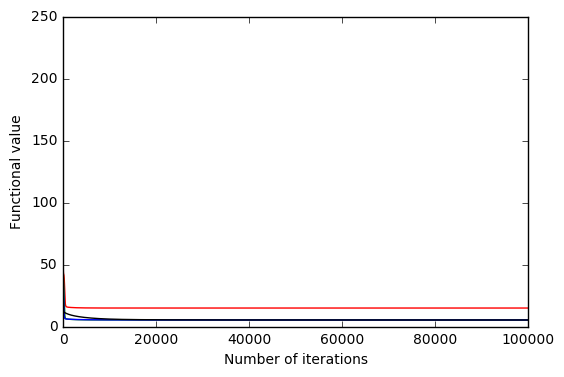

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline  


def plot_res(g_tab,col):
    plt.plot(range(10,MAX_ITER), g_tab[10:], col, linewidth=1.0, linestyle="-")
    #plt.plot(range(2000,MAX_ITER), g_tab[2000:], col, linewidth=1.0, linestyle="-")

colors = ["red", "green", "blue","black"]
plt.figure()
for i in range(0,4):
    print("\nCourbe", i+1, "[",colors[i],"]\n k =", k[i])
    plot_res(mse_tab[i],colors[i])
plt.xlim(10, MAX_ITER)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.show()


In [78]:
U = 1
Umovies = trainingSample.filter(lambda x : x[0] == U).map(lambda x : x[1]).collect()
print(len(Umovies))

P = np.zeros(k)
Q = np.zeros(k)

for m in Umovies :
        p,q,mse = grad_algo(U,m,5,1,MAX_ITER,trainingSample,2)
        P = P + p
print(P)

I = 1907  
Iusers = trainingSample.filter(lambda x : x[1] == I).map(lambda x : x[0]).collect()[:30]
print(len(Iusers))

for u in Iusers :
        p,q,mse = grad_algo(u,I,5,1,MAX_ITER,trainingSample,2)
        Q = Q + q
print(Q)

a = trainingSample.filter(lambda x : x[0] == 1).filter(lambda x : x[1] == 1).collect()
print(a)
print(np.dot(q,p))

#rating = trainingSample.filter(lambda x : x[0] == 1).filter(lambda x : x[1] == 1).map(lambda x : x[2]).collect()[0]
#p,q,mse = grad_algo(1,1,5,1,MAX_ITER,trainingSample,2)
#print(np.dot(p,q),rating)

36
35
[-4.36936056  7.12964772  4.69462682 -2.80226559  4.99411287]
30
[ 5.00613716 -1.23558527 -0.9282347   5.52240953  3.78631992]
[(1, 1, 5.0)]
3.00009337223


In [77]:
moviesRDD = sc.textFile(movieLensHomeDir + "movies.dat").map(parseMovie).setName("movies").cache()
movies_dict = {}
for i,title in moviesRDD.map(lambda x : (x[0],x[1])).collect():
    movies_dict_temp = {i:title}
    movies_dict.update(movies_dict_temp)


def getGenresOfMovie(movie):
    return moviesRDD.filter(lambda x : x[1] == movie).map(lambda y : y[2]).flatMap(lambda x : x.split("|")).collect()

print(movies_dict[I])
print(getGenresOfMovie(movies_dict[I]),"\n")

for i in Umovies:
    print(getGenresOfMovie(movies_dict[i]))

Mulan (1998)
['Animation', "Children's"] 

['Animation', "Children's", 'Musical']
['Musical', 'Romance']
['Drama']
['Animation', "Children's", 'Comedy']
['Action', 'Adventure', 'Comedy', 'Romance']
['Action', 'Adventure', 'Drama']
['Comedy', 'Drama']
['Animation', "Children's", 'Musical']
['Adventure', "Children's", 'Drama', 'Musical']
['Drama']
['Comedy']
['Musical']
['Comedy']
['Animation', "Children's"]
['Animation', "Children's"]
['Drama']
['Romance']
['Drama', 'Romance']
['Animation', 'Comedy', 'Thriller']
['Animation', "Children's"]
['Drama']
['Animation', "Children's", 'Comedy', 'Musical']
['Animation', "Children's"]
['Animation', "Children's", 'Musical']
['Animation', "Children's", 'Musical']
['Thriller']
['Drama']
['Animation', "Children's", 'Comedy']
['Drama']
['Action', 'Crime', 'Romance']
['Action', 'Adventure', 'Fantasy', 'Sci-Fi']
['Action', 'Drama', 'War']
["Children's", 'Drama']
['Animation', "Children's", 'Comedy']
['Crime', 'Drama', 'Thriller']
['Drama']


__Question 3__
> Implement stochastic gradient descent algorithm for Matrix Factorization.

> Provide plots and explanations for your experiments.

> Compare and discuss the results with the (full) gradient algorithm in terms of MSE versus full data passes.

> Discuss the stepsize choice of SGD (e.g. constant v.s. 1/`nb_iter`).

In [ ]:
def stoc_grad_algo(u,i,k,lamb,nb_iter):
    t = 0
    gamma = 0.001
    pu = randomArray(k,-1,1)
    qi = randomArray(k,-1,1)
    rijHat = np.dot(pu,qi)
    rij =  predictiveRatingsRDD.filter(lambda x : x[0]==u).filter(lambda x : x[1]==i)\
                                    .map(lambda x : x[3]).collect()[0]
    mse_tab = np.zeros(nb_iter)
    
    while t < nb_iter:
        #print(i, end=' ')
        mse_grad = MSE_grad(pu,qi,lamb,rij,rijHat)
        mse_tab[t] = MSE(pu,qi,lamb,rij,rijHat)    
        pu = pu - gamma * mse_grad[0]
        qi = qi - gamma * mse_grad[1]
        rijHat = np.dot(pu,qi)
        t += 1
    return pu, qi, mse_tab

Now we will implement Large-Scale Matrix Factorization with Distributed Stochastic Gradient Descent (DSGD) in Spark. 
The algorithm is described in the following article: <br \><br \>
_Gemulla, R., Nijkamp, E., Haas, P. J., & Sismanis, Y. (2011). Large-scale matrix factorization with distributed stochastic gradient descent. New York, USA._<br \><br \>
The paper sets forth a solution for matrix factorization using minimization of sum of local losses.  The solution involves dividing the matrix into strata for each iteration and performing sequential stochastic gradient descent within each stratum in parallel.  DSGD is a fully distributed algorithm, i.e. both the data matrix $R$ and factor matrices $P$ and $Q$ can be carefully split and distributed to multiple workers for parallel computation without communication costs between the workers. Hence, it is a good match for implementation in a distributed in-memory data processing system like Spark. 

__Question 4__

> Implement a `PySpark` version of DSGD.

> Test on different number of cores on a local machine (1 core, 2 cores, 4 cores). Ran the ALS method already implemented in MLlib as a reference for comparison.